# Erstellen einer Umsatzprognose unter Verwendung eines SARIMA-Modells
Autor: Thomas Robert Holy
<br>
Versionsdatum 14.04.2020
<br>
Version 1.0
<br><br>
Visit me on GitHub: https://github.com/trh0ly

## Grundlegende Einstellungen:
### Import von Modulen
Zunächst müssen die notwendigen Module importiert werden, damit auf diese zugegriffen werden kann. 

In [1]:

#----------------
# Web-Scraping
from urllib.request import urlopen
from bs4 import BeautifulSoup
import requests
import re
import string

#----------------
# Forecast
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima.arima import auto_arima
import statsmodels.api as sm

#----------------
# Verschiedenes
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
#import chart_studio.plotly as py
import plotly.graph_objs as go
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
import datetime
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from IPython.core.display import display, HTML


### Optikeinstellungen
Anschließend werden Einstellungen definiert, die die Formatierung der Ausgaben betreffen.
Hierfür wird das Modul `operator` genutzt.
Außerdem wird die Breite des im Folgenden genutzten DataFrames erhöht und die Größe der Grafiken modifiziert, welche später angezeigt werden sollen.

In [2]:

%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;


<IPython.core.display.Javascript object>

In [3]:

display(HTML("<style>.container { width:100% !important; }</style>"))
pd.set_option('display.width', 350)
plt.rcParams['figure.figsize'] = (36, 12) # macht die Plots größer


## Datenbeschaffung und Manipulation
### Web-Scraping historischer Daten von Statista
Mittels Web-Scraping werden historische Daten zu Umsätzen verschiedener Unternehmen von Statista gedownloaded und aufbereitet, bevor diese in zwei separaten Listen gespeichert werden.

In [4]:

#----------------------------------------
# Datensätze
#----------------
# Amazon
#url = 'https://www.statista.com/statistics/273963/quarterly-revenue-of-amazoncom/'
#----------------
# Apple
#url = 'https://www.statista.com/statistics/263427/apples-net-income-since-first-quarter-2005/'
#----------------
# Alibaba
url = 'https://www.statista.com/statistics/323046/alibaba-quarterly-group-revenue/'

#----------------------------------------
# Daten beschaffen und Tabellen extrahieren
html = requests.get(url)
soup = BeautifulSoup(html.text, 'lxml')

chart = soup.find("tbody")
children = chart.find_all("tr")

#----------------------------------------
# Extrahierte Tabellen bereinigen
data = []
for tag in children:
    data_tuple = (tag.text[:6],tag.text[6:])
    data.append(data_tuple)

quartals, revenues = [], []
for i in range(0, len(data)):
    x = data[i][0]
    y = data[i][1]
    quartal = x.replace(' ', '')
    y = y.replace(',', '.')
    revenue = float(y)
    quartals.append(quartal)
    revenues.append(revenue)

#----------------------------------------
# Reihenfolge der extrahierten Daten umkehren und ausgeben
    
quartals = quartals[::-1]
revenues = revenues[::-1]
print(quartals)
print(revenues)


["Q4'13", "Q1'14", "Q2'14", "Q3'14", "Q4'14", "Q1'15", "Q2'15", "Q3'15", "Q4'15", "Q1'16", "Q2'16", "Q3'16", "Q4'16", "Q1'17", "Q2'17", "Q3'17", "Q4'17", "Q1'18", "Q2'18", "Q3'18", "Q4'18", "Q1'19", "Q2'19", "Q3'19", "Q4'19"]
[18.745, 12.031, 15.771, 16.829, 26.179, 17.425, 20.245, 22.171, 34.543, 24.184, 32.154, 34.292, 53.248, 38.579, 50.184, 55.122, 83.028, 61.932, 80.92, 85.148, 117.278, 93.498, 114.924, 119.017, 161.456]


### Weitere Modifikationen
Die von der Website extrahierten Quartalskennzeichnungen in ein für datime interpretierbares Format überführt.

In [5]:

#----------------------------------------
# Quartale in ein für datime interpretierbares Format überführen 
quartals_new = []
for i in quartals:
    x = '20' + str(i[3:])
    y = i[:2]
    z = str(x) + '-' + str(y)
    quartals_new.append(z)
    
quartals_new[:5]


['2013-Q4', '2014-Q1', '2014-Q2', '2014-Q3', '2014-Q4']

## Erstellung eines DataFrames und Visualisierung
### Generierung des DataFrames
Es wird ein DataFrame erzeugt, welcher die Umsätze zum jeweiligen Quartal enthält. 

In [6]:

#----------------------------------------
# DataFrame mit bereinigten Daten erzeugen
original_data = pd.DataFrame({'Periode':quartals_new, 'Umsatz':revenues})
original_data['Periode'] = pd.to_datetime(original_data['Periode'].str.replace(r'(Q\d) (\d+)', r'\2-\1'), errors='coerce')
original_data.tail()


,Periode,Umsatz
20,2018-10-01,117.278
21,2019-01-01,93.498
22,2019-04-01,114.924
23,2019-07-01,119.017
24,2019-10-01,161.456


### Visualisierung der Daten
Der DataFrame wird visualisiert.

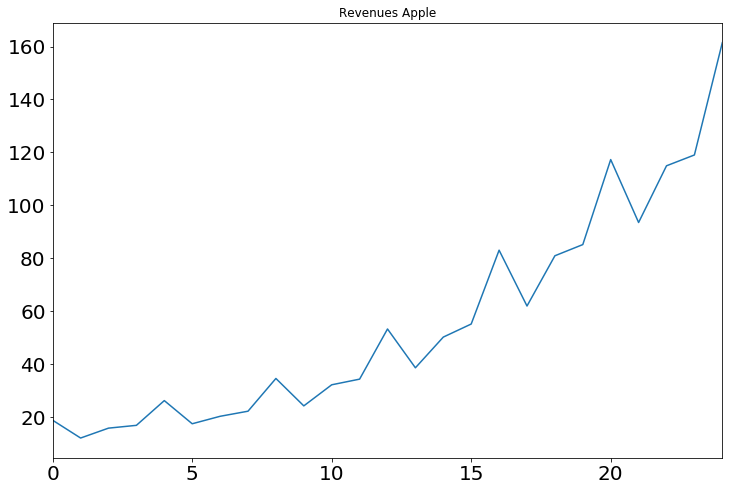

In [7]:

#----------------------------------------
# Plotten der Daten
original_data.Umsatz.plot(figsize=(12,8), title='Revenues Apple', fontsize=20)


## Datenanalyse und Vorbereitung für die Prognose
### Datenanalyse - Komponentenanalyse
Die Zeitreihe wird in ihre einzelne Komponenten zerlegt, d.h. es werden Trend, Saisonalität und Residuum aus der beobachteten Zeitreihe extrahiert und separat visualisiert.

<Figure size 2592x864 with 0 Axes>

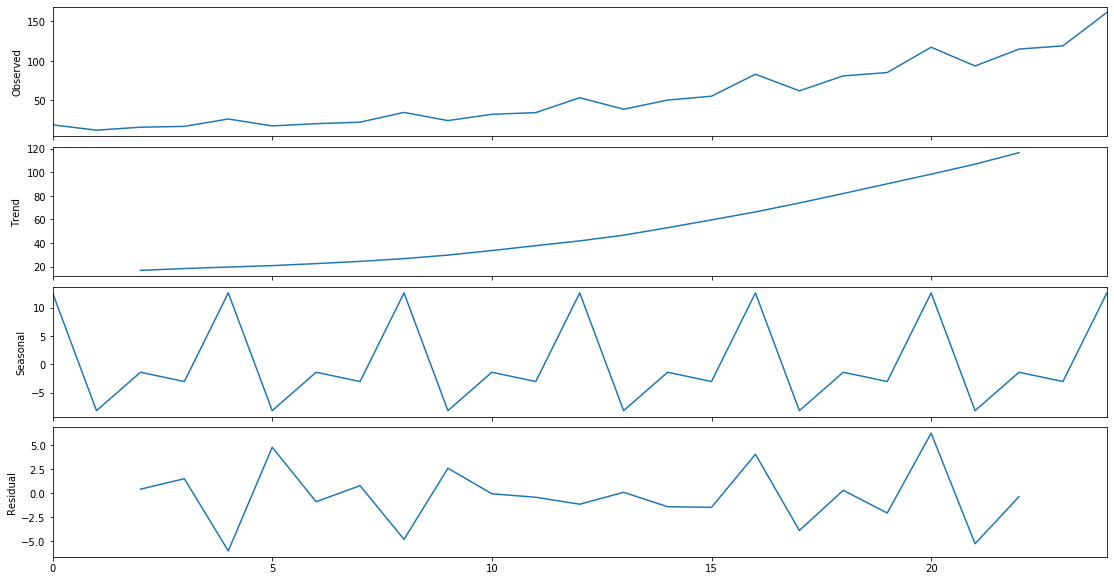

In [8]:

#----------------------------------------
# Dekomposion der Daten und plotten
decomposition = seasonal_decompose(original_data.Umsatz, freq=4)  
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(15, 8)


### Datenanalyse - Stationarität
Die beobachtete Zeitreihe wird auf Stationarität hinsichtlich Erwartungswert und Standardabweichung untersucht. 
Um eine Prognose vornehmen zu können müssen stationäre Daten vorliegen.
Dies wird später durch die "Auto-SARIMA-Funktion automatisch sichergestellt.
Hinweis: Die Komponenten sind (noch) nicht stationär.

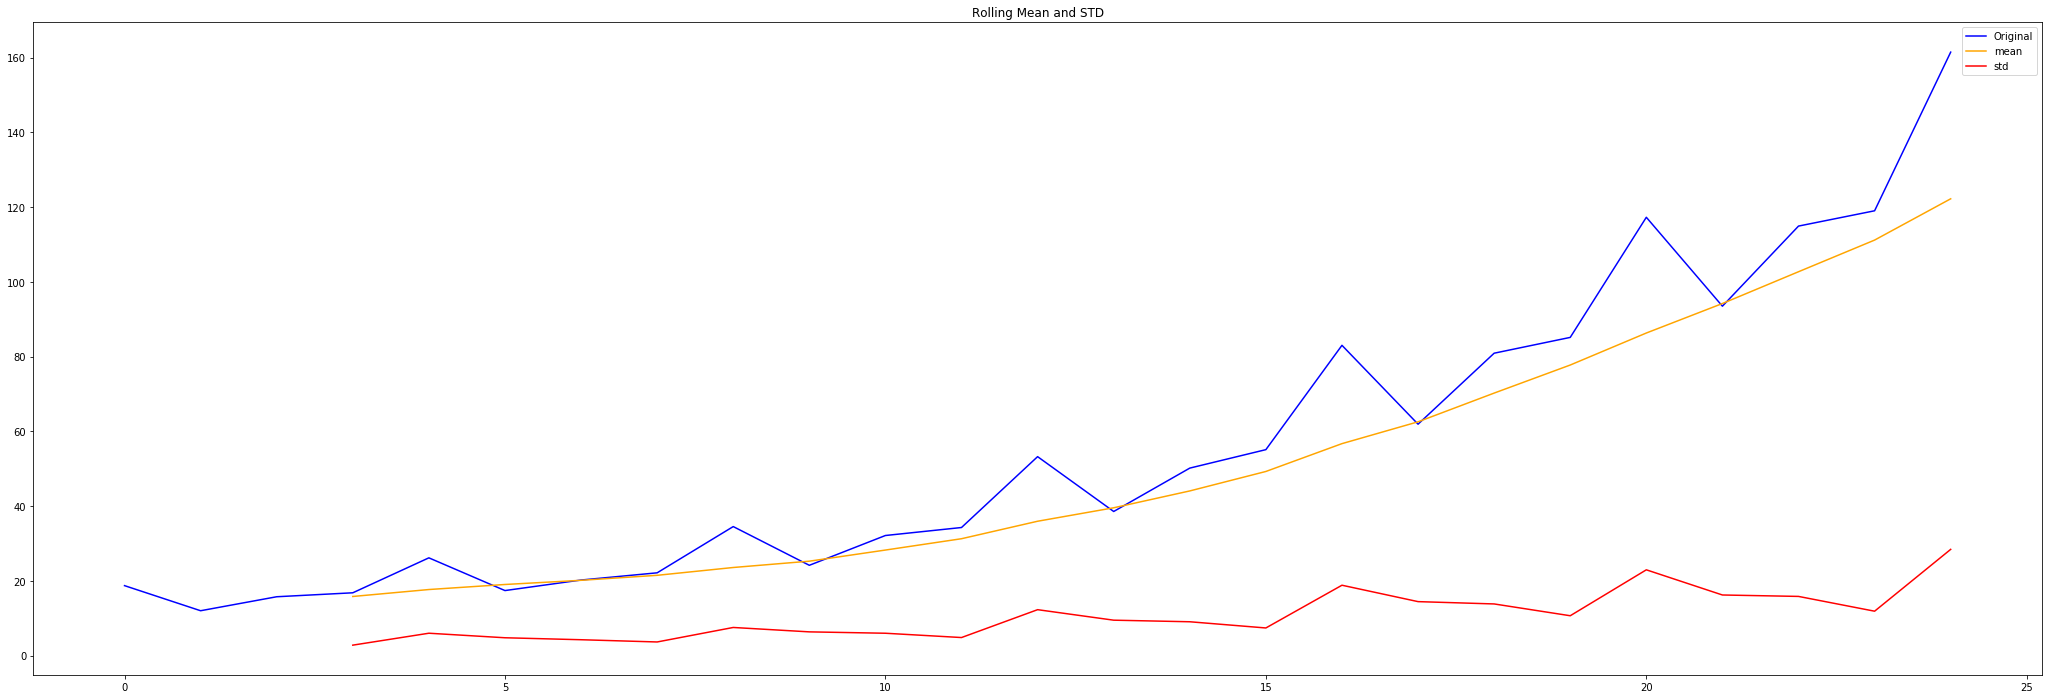

In [9]:

#----------------------------------------
# Berechnung gleitender Durchschnitt sowie gleitende Standardabweichung
rolmean = original_data.rolling(window=4).mean()
rolstd = original_data.rolling(window=4).std()

#----------------------------------------
# Plotten
orig = plt.plot(original_data.Umsatz, color='blue', label='Original')
mean = plt.plot(rolmean, color='orange', label='mean')
std = plt.plot(rolstd, color='red', label='std')
plt.legend(loc='best')
plt.title('Rolling Mean and STD')
plt.show()


### Vorbereitung zur Prognose - Erstellung eines Test- und eines Trainingsdatensatzes
Der ursprüngliche Datensatz wird in einen Test- und einen Traingsdatensatz zerlegt. Ersterer dient dazu die Güte des Modells beurteilen zu können (grafisch), während letzterer zum Traing des modells verwendet wird.

#### Traingsdatensatz

In [10]:

#----------------------------------------
# Trainings-Datensatz
train_df = original_data.copy(deep=True)
train_df.drop(train_df.tail(6).index,inplace=True)
train_df.tail(6)


,Periode,Umsatz
13,2017-01-01,38.579
14,2017-04-01,50.184
15,2017-07-01,55.122
16,2017-10-01,83.028
17,2018-01-01,61.932
18,2018-04-01,80.920


#### Testdatensatz

In [11]:

#----------------------------------------
# Test-Datensatz
test_df = original_data.tail(6)
test_df


,Periode,Umsatz
19,2018-07-01,85.148
20,2018-10-01,117.278
21,2019-01-01,93.498
22,2019-04-01,114.924
23,2019-07-01,119.017
24,2019-10-01,161.456


## Prognose
### Anwendung des (Auto-)SARIMA-Modells
Es erfolgt eine automatisierte Suche nach bestem Modell bzw. den besten Hyperparametern des SARIMA-Modells anhand des AIC.

In [12]:

decomposition = auto_arima(train_df.Umsatz, start_p=1, start_q=1,
                           max_p=5, max_q=5, max_d=5, m=4,
                           start_P=0, seasonal=True,
                           d=None, D=None, trace=True,
                           error_action='ignore', 
                           information_criterion='aic', 
                           n_jobs=10, scoring='mse',
                           suppress_warnings=True, 
                           stepwise=True)


C:\Users\Pablo\Anaconda3\lib\site-packages\pmdarima\arima\auto.py:234: UserWarning:

stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.



Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 0, 1, 4); AIC=129.703, BIC=134.155, Fit time=0.110 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 4); AIC=145.055, BIC=146.836, Fit time=0.004 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 0, 0, 4); AIC=117.705, BIC=121.267, Fit time=0.043 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 1, 4); AIC=130.005, BIC=133.567, Fit time=0.090 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 0, 0, 4); AIC=136.970, BIC=139.641, Fit time=0.014 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 0, 0, 4); AIC=113.647, BIC=118.099, Fit time=0.088 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 0, 1, 4); AIC=115.646, BIC=120.988, Fit time=0.183 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(2, 0, 0, 4); AIC=115.545, BIC=119.106, Fit time=0.058 seconds
Fit ARIMA: order=(2, 1, 0) seasonal_order=(2, 0, 0, 4); AIC=115.472, BIC=120.814, Fit time=0.143 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(2, 0, 0, 4);

### Ausgabe Informationskriterium 
Ausgabe desjenigen Informationskriteriums, welches sich nach dem Modelllauf als bestmöglich erweist.

In [13]:

decomposition.aic()


113.64688894445932

### Anwendung des Modells mit dem besten Fit auf den Trainingsdatensatz

In [14]:

mod = sm.tsa.statespace.SARIMAX(train_df.Umsatz,
                                order=(1, 1, 0),
                                seasonal_order=(2, 0, 0, 4),
                                enforce_stationarity=True,
                                enforce_invertibility=True)
decomposition = mod.fit()
decomposition.summary()


C:\Users\Pablo\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:981: UserWarning:

Non-stationary starting seasonal autoregressive Using zeros as starting parameters.



<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                            Umsatz   No. Observations:                   19
Model:             SARIMAX(1, 1, 0)x(2, 0, 0, 4)   Log Likelihood                 -52.818
Date:                           Tue, 14 Apr 2020   AIC                            113.636
Time:                                   10:40:30   BIC                            117.197
Sample:                                        0   HQIC                           114.127
                                            - 19                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3896      0.276     -1.411      0.158      -0.931       0.152
ar.S.L4        1.5954      0.315      5.065      0.000       0.978       2.213
ar.S.L8       -0.6489      0.382     -1.699      0.089      -1.397       0.100
sigma2         8.6975      4.496      1.935      0.053      -0.114      17.509
===================================================================================
Ljung-Box (Q):                         nan   Jarque-Bera (JB):                 1.48
Prob(Q):                               nan   Prob(JB):                         0.48
Heteroskedasticity (H):               9.94   Skew:                             0.57
Prob(H) (two-sided):                  0.01   Kurtosis:                         2.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Ermittlung des Forcast und Visualisierung
#### Ermittlung Forcast
Die nächsten sechs an den Traingsdatensatz anknüpfenden Perioden werden prognostiziert.

In [15]:

forecast = decomposition.forecast(6)


#### Visualisierung Forecast v.s. Testdatensatz (historische Daten)

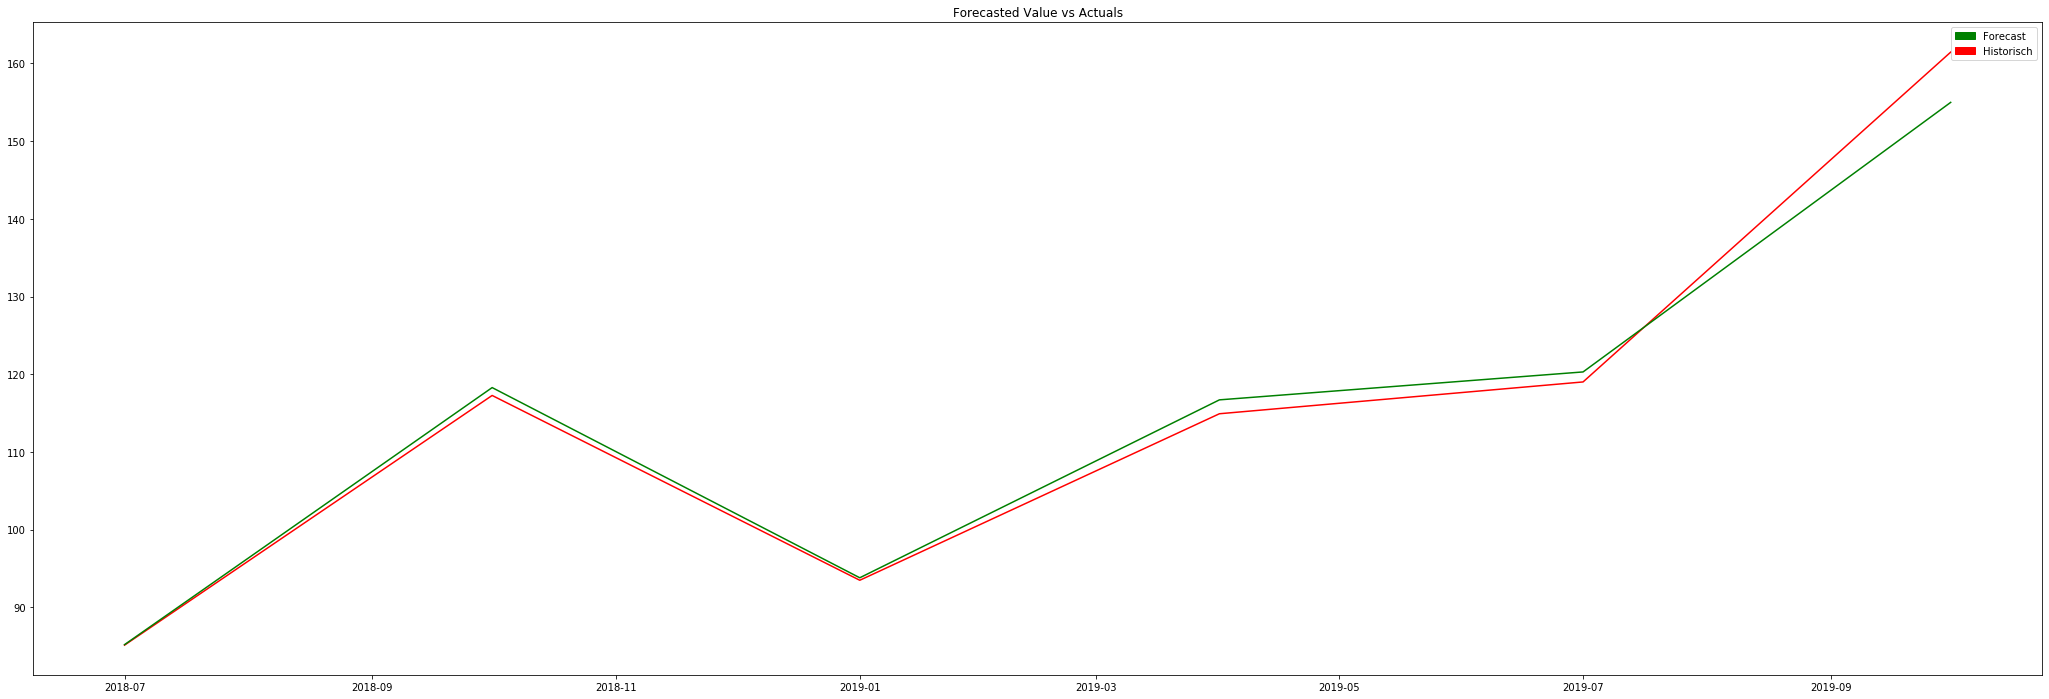

In [16]:

#----------------------------------------
# Forecast DataFrame vs Test-DataFrame 
yActual = test_df['Umsatz'].values.tolist()
yPredicted = forecast.head(6).values.tolist()
periode = test_df.Periode
#----------------------------------------
# Ploten
plt.plot(periode,yActual, color='red') # Rot
plt.plot(periode,yPredicted, color='green') # Grün
green_patch = mpatches.Patch(color='green', label='Forecast') 
red_patch = mpatches.Patch(color='red', label='Historisch') 
plt.legend(handles=[green_patch, red_patch])
plt.title("Forecasted Value vs Actuals")
plt.show()


#### Darstellung als DataFrame

In [17]:

compare_df = pd.DataFrame()
compare_df['Period'] = test_df.Periode
compare_df['Umsatz_original'] = yActual# np.exp(yActual)
compare_df['Umsatz_Forecast'] = yPredicted #np.exp(yPredicted)
compare_df['PctChg'] = abs(round(((compare_df.Umsatz_original - compare_df.Umsatz_Forecast) / compare_df.Umsatz_original * 100), 2))
compare_df


,Period,Umsatz_original,Umsatz_Forecast,PctChg
19,2018-07-01,85.148,85.211994,0.08
20,2018-10-01,117.278,118.290386,0.86
21,2019-01-01,93.498,93.817991,0.34
22,2019-04-01,114.924,116.711655,1.56
23,2019-07-01,119.017,120.304466,1.08
24,2019-10-01,161.456,154.990847,4.00


### Fehlermetriken
Im Mittel liegt das Modul um 1,32% neben den tatsächlichen Beobachtungen 

In [18]:

compare_df.PctChg.mean()


1.32

### Mean Squared Error
Der MSE nimmt im Vergleich zu Modellen mit anderen Parametern einen recht kleinen Wert an, sodass das gewählte Modell recht gut performt. 

In [19]:
mean_squared_error(compare_df['Umsatz_original'], compare_df['Umsatz_Forecast'])

7.9638162771338985

### Bestimmtheitsmaß
Das bestimmtheitsmaß nimmt einen recht hohen wert an.
Das beweutet, dass das Modell relativ viel der Varianz im Testdatensatz erklären kann und damit für die Prognose gut geeignet ist. 

In [20]:
r2_score(compare_df['Umsatz_original'], compare_df['Umsatz_Forecast'])

0.9864740310635753

## Prognose für die nächsten sechs Quartale
### Forecast erzeugen und in DataFrame darstellen
Die nächsten sechs Quartale werden prognostiziert und visualisiert. 

In [21]:

#----------------------------------------
# Forecast
periods_forcast = range(1,6)
x = forecast = decomposition.forecast(11)
#----------------------------------------
# Erstellung DataFrame
forecast = pd.DataFrame({'Periode':periods_forcast, 'Umsatz': x[6:]})
forecast.head(6)


,Periode,Umsatz
25,1,129.627898
26,2,153.835216
27,3,156.781178
28,4,190.657565
29,5,166.072112


In [22]:

original_data['Umsatz'] = original_data['Umsatz']
original_data = original_data.append(forecast[1:], sort=True)
_ = original_data.drop(['Periode'], axis=1) 


### Visualisierung

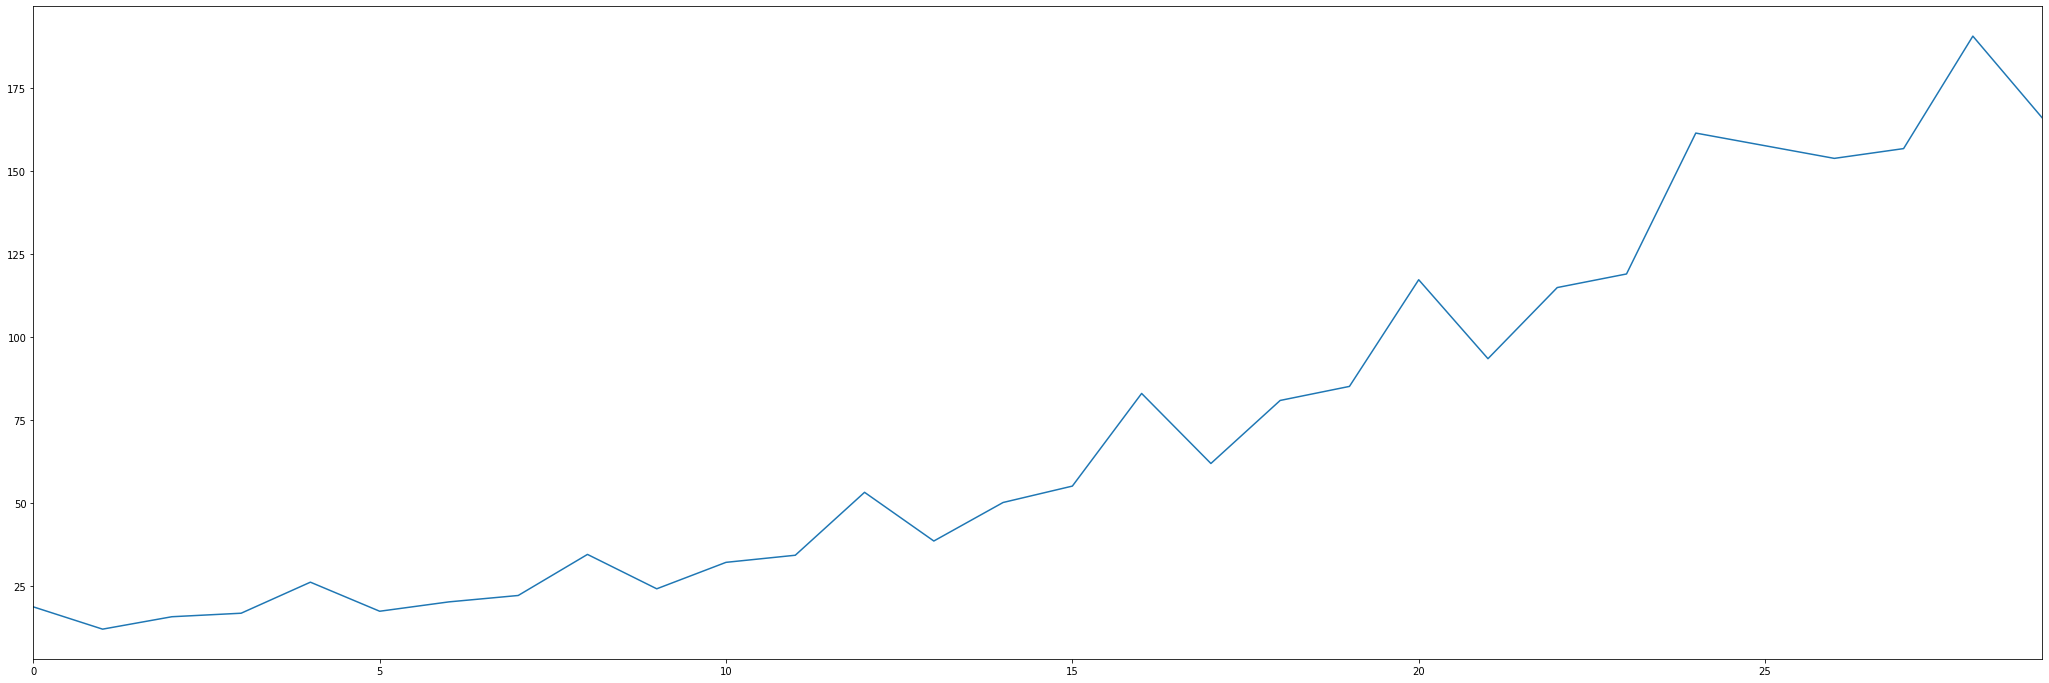

In [23]:

original_data['Umsatz'].plot()
